In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('/Users/uqhkamel/PhD/Code/AKI_mimiciv/mimic-code-main/mimic-iv/src')
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import sqlite3

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score


from pickle import dump
from dfwiz import dfwiz
from dfwiz import dfwiz_compare

from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import recall_score


# from sklearn.pipeline import Pipeline


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample

import copy

from sklearn import metrics


from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, scale, melt, unmelt, \
                             remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap,get_dates
from utils.pipelines import scale_impute_via_pipeline

In [3]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
pd.set_option("display.max_columns", None)

In [4]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

In [5]:

import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn')
sns.set_theme(style="ticks")
mpl.rcParams['figure.figsize'] = (10,6)

# Title
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 20

# Axes labels
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelweight'] = 'bold'

# Grid and thicks
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
#mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['ytick.left'] = False

# Legend
mpl.rcParams['legend.facecolor'] = 'w'
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['legend.edgecolor'] = 'blue'
mpl.rcParams['legend.borderpad'] = 0.6

# Other
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['scatter.edgecolors'] = None




_________
### upsampler func def

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

class upsampler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X

    def sample(self, X, y = None):
        X = np.array(X)
        y = np.array(y)
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y[y == 0]], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y[y == 1]], y[y == 1]
        else:
            print(X[y[y == 0]].shape)
            X1, y1 = resample(X[y[y == 1]], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y[y == 0]], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  

        return X_out, y_out


_________
### accuracy func def

In [7]:
def confusion_matrix_plot(y, y_pred, y_pred_proba):

    fpr, tpr, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
    score = metrics.roc_auc_score(y,  y_pred_proba[::,1])

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(round(score,2)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()


    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7,7))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
    accuracy = accuracy_score(y, y_pred)

    # print("Accuracy: %.2f%%" % (accuracy * 100.0))


    cr = classification_report(y, y_pred)
    print("\r\n"+"Classification report"+"\r\n")
    print(cr)

    print("\r\n_________________________________________")
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn+fp)
    print("\r\n"+"Specificity"+"\r\n")
    print(round(specificity,2))

    print("\r\n_________________________________________")



In [8]:
from sklearn.utils import resample

def up_sample(X_train_raw, y_train_raw,col_name):

    # upsampling X_train and y_train
    df_upsampled = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True)

    X_minority = df_upsampled[df_upsampled[col_name]==1]
    X_majority = df_upsampled[df_upsampled[col_name]!=1]

    n_samples = X_majority.shape[0]
    X_minority_upsampled = resample(X_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=n_samples,    # to match majority class
                                    random_state=42) # reproducible results

    df_upsampled = pd.concat([X_majority, X_minority_upsampled]).sample(frac=1)

    y_train_out = df_upsampled[[col_name]]
    X_train_out = df_upsampled.drop([col_name], axis=1)

    return X_train_out, y_train_out

_________
### define cross validation function

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold



def param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 5, sample_ratio = 0.2, refit=True, use_error=True, multi_class=False, average_metric='macro'):

    print("This search selects lower indexes of search list if their score is within the error of maximum score.")
    print("Putting parameters for less complicated model on the left side of the grid lists leads to better generalisation. ")
    print(" ")

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    n_train = int(sample_ratio * len(y_train))
    X_train_s, y_train_s  = resample(X_train, y_train, n_samples=n_train, stratify=y_train)

    best_score = {}
    best_params = {}
    for k, v in param_grid.items():
        # best_params[k] = v[int(len(v)/2)-1]
        best_params[k] = v[0]
    best_params_m1 = best_params.copy()
    print("start_params:", best_params)

    score = {}
    score_std = {}

    for i_iter in range(max_iter):
        print("_"*100)
        print("Iteration", i_iter)

        for k, v in param_grid.items():

            best_params1 = best_params.copy()
            del best_params1[k]  

            score[k] = v.copy()
            score_std[k] = v.copy()

            for i_param, val_param in enumerate(v):
                cv_sc = np.zeros(cv)

                for i_cv in range(cv):

                    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_s, y_train_s, test_size=0.2, stratify=y_train_s, shuffle=True) # 80% training and 20% test

                    p1 = copy.deepcopy(pipe)
                    p1.set_params(**best_params1)
                    params2 = {k:val_param}
                    p1.set_params(**params2)

                    p1.fit(X_train2, y_train2.ravel())
                    # X,y = p1.named_steps['resample'].fit_resample(X_test2, y_test2)
                    X,y = X_test2, y_test2
                    # y_pred_proba = p1.predict_proba(X)
                    # cv_sc[i_cv] = metrics.roc_auc_score(y,  y_pred_proba[::,1])
                    y_pred = p1.predict(X)
                    if(multi_class):
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred, average=average_metric)
                    else:
                        cv_sc[i_cv] = metrics.f1_score(y, y_pred)

                    i_cv = i_cv + 1

                score[k][i_param] = cv_sc.mean()
                score_std[k][i_param] = cv_sc.std()

            print("")
            print(k)
            print(v)
            print(score[k])

            best_params[k] = v[np.argmax(score[k])]
            best_score[k] = score[k][np.argmax(score[k])]

            if use_error:
                for i_b in  range(np.argmax(score[k]),-1,-1):
                    err1 = (score_std[k][i_b] + score_std[k][v.index(best_params[k])] ) / 4
                    # print("err1")
                    max_del = max(score[k]) - err1
                    # print( i_b, score[k][i_b], max(score[k]), err1, max_del )
                    if score[k][i_b] >= max_del:
                        best_params[k] = v[i_b]
                        best_score[k] = score[k][i_b]

            print("best_param:",  v[np.argmax(score[k])], "score:", max(score[k]))
            print("selected_param:",  best_params[k], "score:", best_score[k])
            

        
        print("")
        print("best_params =", best_params)
        print("")
        if best_params_m1 == best_params:
            print("")
            print("")
            print("Early stop. No improvement in the last iteration.")
            break
        best_params_m1 = best_params.copy()

    param_graph_plot(score)

    if refit:
        print("Refitting final model...")
        pipeline_final = copy.deepcopy(pipe)
        pipeline_final.set_params(**best_params)
        pipeline_final.fit(X_train, y_train.values.ravel())
    else:
        pipeline_final = None

    return score, best_params, pipeline_final
    

def param_graph_plot(score):
    ax = {}
    fig = {}
    for i, (k, v) in enumerate(score.items()):
        fig[k], ax[k] = plt.subplots()

    for k, v in score.items():
        x = score[k]
        y = v
        ax[k].plot(x,y,"-o", label="Score")
        # ax[k].set_ylim([0.5, 1])
        ax[k].set_title(k)
        ax[k].legend()

________
### Define upsampler

In [10]:

from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.utils import resample


class upsampler(BaseEstimator): 
    def __init__(self):
        return None

    def fit_resample(self, X, y = None):
        X = np.array(X)
        y = np.array(y).ravel()
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y == 0], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y == 1], y[y == 1]
        else:
            X1, y1 = resample(X[y == 1], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y == 0], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  
        return X_out, y_out

________
### Load data and select index

In [11]:
# create a database connection
sqluser = 'uqhkamel'
dbname = 'mimiciv'
schema_name = 'mimic_derived'

In [12]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [13]:
# query = "select * from all_scr_preadmission_75_JOIN"
# data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id','hadm_id'])
query = "select * from all_scr_preadmission_75_JOIN_6hr_fix"
data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])
data.drop('hadm_id', inplace=True, axis=1)

## Rename columns

In [14]:
data.rename(columns={
'egfr_epi_scr_max':'eGFR',
'pt_max':'Prothrombin time',
'invasive_vent':'invasive ventilation',
'congestive_heart_failure':'congestive heart failure',
'diabetes_type2':'diabetes Type2',
'resp_rate_max':'respiratory rate max',
'sbp_max':'systolic blood pressure max',
'heart_rate_max':'heart rate max',
'dbp_max':'diastolic blood pressure max',
'spo2_min':'oxygen saturation min',
'spo2_max':'oxygen saturation max',
'bicarbonate_max':'bicarbonate max',
'bicarbonate_min':'bicarbonate min',
'ckd':'chronic kidney disease',
'wbc_max':'white blood count max',
'wbc_min':'white blood count min',
'bun_min':'blood urine nitrogen min',
'creatinine_min':'creatinine min',
'creatinine_max':'creatinine max',
'hematocrit_min':'hematocrit min',
'sodium_max':'sodium max',
'chloride_max':'chloride max',
'hemoglobin_min':'hemoglobin min',
'aniongap_max':'aniongap max',
'supplemental_oxygen':'supplemental Oxygen',
'calcium_max':'calcium max',
'urineoutput_24hr':'urine output',
'myocardial_infarct':'myocardial infarction',
'aniongap_min':'aniongap min',
'calcium_min':'calcium min',
'potassium_max':'potassium_max',
'platelets_min':'platelets min'
}, inplace=True)

## Remove useless columns

In [15]:
drop_X   = [
'potassium_min',
'temperature_min',
'glucose_max',
'glucose_min',
'sodium_min',
'temperature_mean',
'egfr_mdrd_scr_max',
'pt_min',
'inr_min',
'inr_max',
'weight_admit',
'weight_min',
'ptt_max',
'ptt_min',
'platelets_max',
'resp_rate_min',
'resp_rate_mean',
'sbp_mean',
'sbp_min',
'chloride_min',
'heart_rate_mean',
'heart_rate_min',
'dbp_min',
'dbp_mean',
'non_invasive_vent',
'wbc_bd_min',
'wbc_bd_max',
'chronic_kidney_disease',
'arbs_acei',
'hematocrit_max',
'bun_max'
]


data.drop(drop_X, inplace=True, axis=1)

In [16]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


In [17]:
data.shape

(46300, 80)

In [18]:
data.day_detection_kdigo_grade_1.value_counts()

9999999.0    25322
1.0          15283
2.0           3853
3.0           1255
0.0            587
Name: day_detection_kdigo_grade_1, dtype: int64

In [19]:
outcome_var = []
outcome_var.append('day_detection_kdigo_grade_1')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [20]:
data.shape

(30430, 80)

In [21]:
data[data['min_day_rrt_present']<=1].shape

(64, 80)

In [22]:
outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [23]:
# data[data['ckd']==1].shape

In [24]:
# data = data[data['ckd']==0]

In [25]:
data[data['kidney_transplant']==1].shape

(97, 80)

In [26]:
data = data[data['kidney_transplant']==0]

In [27]:
# data[data['min_day_rrt_present']<=1].shape
data[data['min_day_rrt_present']<=1].shape

(0, 80)

In [28]:
data.shape

(30269, 80)

In [29]:
prediction_window = 3

data.loc[(( (data['aki_kdigo_grade_1']== 1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window))), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [30]:
data.outcome.value_counts()

0.0    25212
1.0     5057
Name: outcome, dtype: int64

In [31]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
'kidney_transplant'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

In [32]:
data.shape

(30269, 72)

## Missingness percentage

In [33]:
perc = 20 # remove rows with NaN is 80 or more in each row
min_count =  int(((100-perc)/100)*data.shape[0])
data.dropna(axis=1, thresh = min_count, inplace=True)

In [34]:
data.shape

(30269, 61)

In [35]:
data_missingness = data.isna().sum()/len(data)*100
print(data_missingness.to_clipboard())

None


In [36]:
# data_missingness = data.isna().sum()
# print(data_missingness.to_string())

In [37]:
# data.reset_index().drop_duplicates(subset=['stay_id','subject_id','hadm_id']).set_index(['stay_id','subject_id','hadm_id'])

In [38]:
# # remove unpopulated columns
# data.pipe(sort)\
#               .pipe(replace_inf).pipe(drop_empty)

In [39]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

In [40]:
data_cat = pd.get_dummies(data_cat,prefix=[''], prefix_sep='', columns = ['ethnicity'], drop_first=True)

In [41]:
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True, how='inner')

In [42]:
processed.shape

(30269, 63)

In [43]:
processed.is_mdrd.value_counts()

1    18546
0    11723
Name: is_mdrd, dtype: int64

In [44]:
(processed['is_mdrd'].sum()/processed.shape[0])*100

61.2706068915392

In [45]:
tmp1 = processed[processed['is_mdrd']==1]
tmp1.aki_kdigo_grade_1.value_counts()

0    15852
1     2694
Name: aki_kdigo_grade_1, dtype: int64

In [46]:
tmp2 = processed[processed['is_mdrd']==0]
tmp2.aki_kdigo_grade_1.value_counts()

0    9360
1    2363
Name: aki_kdigo_grade_1, dtype: int64

In [47]:
tmp2.shape

(11723, 63)

In [48]:
# processed.is_mdrd.value_counts()
processed['is_mdrd'].sum()/len(processed)*100

61.2706068915392

In [49]:
processed2 = processed.copy()
processed.drop(['egfr_epi_scr','egfr_mdrd_scr'], inplace=True, axis=1)


In [50]:
(processed[processed['aki_kdigo_grade_3']==1].shape[0])/processed.shape[0]

0.00432786018698999

In [51]:
(processed[processed['aki_kdigo_grade_3']==1].shape[0])

131

In [52]:
(processed[processed['aki_kdigo_grade_1']==1].shape[0])

5057

In [53]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3',
    'is_mdrd',
    'hospital_expire_flag'

]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y)).pipe(remove_outliers)
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [54]:
df_y.shape

(30269, 1)

In [55]:
df_y.outcome.value_counts()

0.0    25212
1.0     5057
Name: outcome, dtype: int64

In [56]:
X, y = df_X, df_y

from sklearn.model_selection import train_test_split

X_train_0, X_valid, y_train_0, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y) # 

X_train, X_test, y_train, y_test = train_test_split(X_train_0, y_train_0, test_size=0.25, random_state=42, shuffle=True, stratify=y_train_0) #0.25 *0.8 = 0.2 for test and 0.75*0.8 = 0.60 for train

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [57]:
# AKI_1_df.hospital_expire_flag.value_counts()

In [58]:
# AKI_1_df.query("hospital_expire_flag==1").shape[0]/AKI_1_df.shape[0]

In [59]:
# AKI_0_df.hospital_expire_flag.value_counts()

In [60]:
# AKI_0_df.query("hospital_expire_flag==1").shape[0]/AKI_0_df.shape[0]

In [61]:
X_train,  y_train = [
    df.reset_index(drop=True)
    for df in up_sample(X_train, y_train,'outcome')]

In [62]:
df_y.value_counts()

outcome
0.0        25212
1.0         5057
dtype: int64

In [63]:
df_y.query("outcome==1").sum()/df_y.shape[0]

outcome    0.167069
dtype: float64

In [64]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

train_df = pd.merge(X_train_copy, y_train_copy, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))
train_df.drop([col for col in train_df.columns if 'drop' in col], axis=1, inplace=True)

# processed_copy = processed2.copy()
# processed_copy = pd.merge(processed_copy, train_df, how='inner', left_index=True, right_index=True, suffixes=('', '_drop'))
# processed_copy.drop([col for col in processed_copy.columns if 'drop' in col], axis=1, inplace=True)

In [65]:
perc = 20 # remove rows with NaN is 80 or more in each row
min_count =  int(((100-perc)/100)*train_df.shape[0])
# train_df.dropna(axis=1, thresh = min_count, inplace=True)
data_missingness = train_df.isna().sum()/len(train_df)*100
print(data_missingness.to_string())

diastolic blood pressure max     0.492497
urine output                     1.170093
female                           0.000000
obesity_icd                      0.000000
heart rate max                   0.178489
sodium max                       0.102466
chronic kidney disease           0.000000
supplemental Oxygen              0.000000
temperature_max                  5.139816
oxygen saturation min            0.195016
congestive heart failure         0.000000
chloride max                     0.085939
hemoglobin min                   0.158657
systolic blood pressure max      0.492497
chronic_heart_failure            0.000000
hfnc                             0.000000
blood urine nitrogen min         0.082634
myocardial infarction            0.000000
calcium max                     16.308587
cyclosporine                     0.000000
Prothrombin time                 7.899782
peripheral_vascular_disease      0.000000
platelets min                    1.956766
chronic_liver_disease            0

In [66]:
train_df.dropna(axis=1, thresh = min_count, inplace=True)
# data_missingness = train_df.isna().sum()/len(train_df)*100
data_missingness = train_df.isna().sum()
print(data_missingness.to_clipboard())

None


In [67]:
train_df.shape

(30254, 53)

___________________
### Define pipeline

In [68]:
import lightgbm as lgbm  # standard alias

pipe = Pipeline(steps=[
# ('resample', upsampler()),
('scaler', MinMaxScaler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('model', lgbm.LGBMClassifier(n_jobs=-1, n_estimators=300))
])

___________________
### Cross validation search

In [69]:
# ########### **************************************8
# # Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


# param_grid ={'model__num_leaves': [6, 10, 20, 50], 
#              'model__min_child_samples': [100, 200, 300, 400, 500], 
#              'model__min_child_weight': [1e-5,  1e-2,  1,  1e2,  1e4],
#              'model__subsample' : [0.2, 0.5, 0.8], 
#              'model__reg_alpha': [0, 1e-1, 1, 5,  10, 50, 100],
#              'model__reg_lambda': [0, 1e-1, 1,  10,  50, 100]}






# score, best_params, pipeline_final = param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 3, sample_ratio = 0.1, refit=False, use_error=True)

# # dump(pipeline_final , open('pipeline_final_LGBM.pkl', 'wb'))

In [70]:
# import lightgbm as lgbm  # standard alias

# pipe = Pipeline(steps=[
# # ('resample', upsampler()),
# ('scaler', MinMaxScaler()),
# ('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan, sample_posterior=True)),
# ('model', lgbm.LGBMClassifier(n_jobs=-1))
# ])

__________
### Fitting Pipeline one time



______________________________________________________________________________________________________________________________________________________

Train Accuracy:



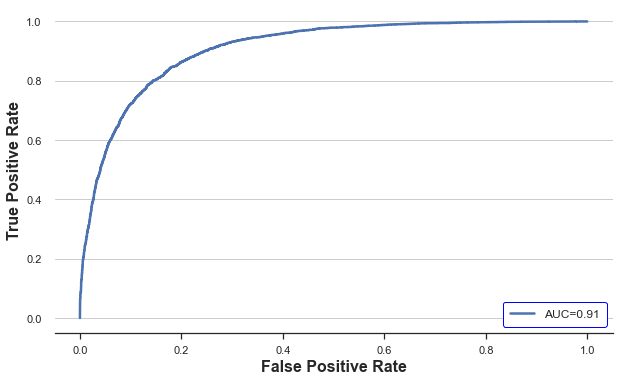

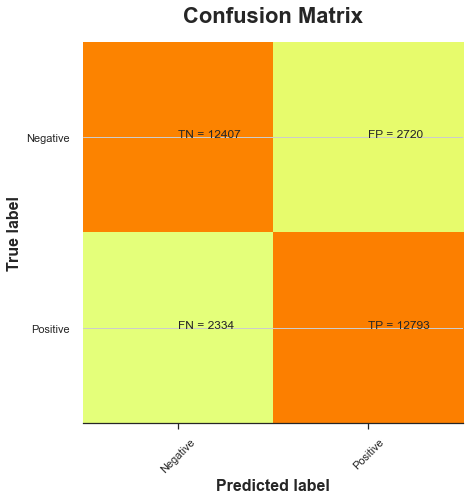


Classification report

              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83     15127
         1.0       0.82      0.85      0.84     15127

    accuracy                           0.83     30254
   macro avg       0.83      0.83      0.83     30254
weighted avg       0.83      0.83      0.83     30254


_________________________________________

Specificity

0.82

_________________________________________


In [71]:
# manual params setting
best_params = {'model__n_estimators': 400,'model__num_leaves': 25, 'model__min_child_samples': 20, 'model__min_child_weight': 1, 'model__subsample': 0.2, 'model__reg_alpha': 50, 'model__reg_lambda': 0}

# Or get parameters from search above
best_params2 = best_params

sample_ratio = 1
n_samples = int(len(X_train)*sample_ratio)
X, y = resample(X_train.values, y_train.outcome.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
pipeline_final = copy.deepcopy(pipe)
pipeline_final.set_params(**best_params2)
pipeline_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = pipeline_final.predict(X)
y_pred_proba = pipeline_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)


# dump(pipeline_final, open('pipe_rf.pkl', 'wb'))


__________
### Test accuracy

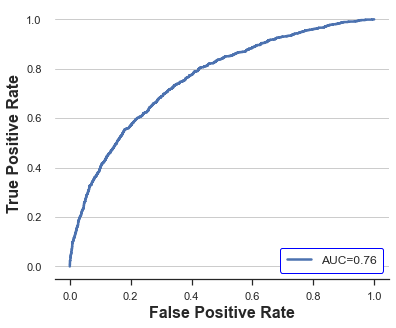

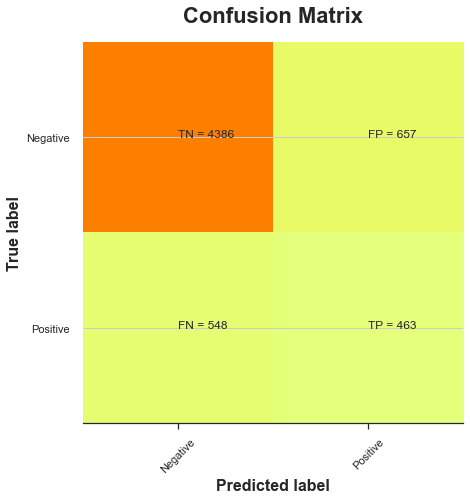


Classification report

              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88      5043
         1.0       0.41      0.46      0.43      1011

    accuracy                           0.80      6054
   macro avg       0.65      0.66      0.66      6054
weighted avg       0.81      0.80      0.80      6054


_________________________________________

Specificity

0.87

_________________________________________


In [72]:

# X,y = pipeline_final.named_steps['resample'].fit_resample(X_test, y_test)
plt.rcParams["figure.figsize"] = (6,5)
clf_threshold = 0.63

X,y = X_valid.values, y_valid.values
# X,y = X_test.values, y_test.values

y_pred = pipeline_final.predict(X)
y_pred_proba = pipeline_final.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= clf_threshold).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


In [73]:
from sklearn.feature_selection import mutual_info_classif


def scale_impute(df, pipe):
    data_scaled = pipe.named_steps['scaler'].transform(df)
    df_scaled = pd.DataFrame(data_scaled, columns=df.columns)
    data_imputed = pipe.named_steps['imputer'].transform(df_scaled)
    df_result = pd.DataFrame(data_imputed, columns=df.columns)
    return df_result

In [ ]:
# from sklearn.calibration import calibration_curve, CalibrationDisplay

# y_prob = pipeline_final.predict_proba(X_valid)[:, 1]
# prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=20)

# disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
# disp.plot()

In [ ]:
# fpr_XGB_grade123, tpr_XGB_grade123, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
# %store fpr_XGB_grade123
# %store tpr_XGB_grade123

In [ ]:
# %store -r fpr_RF_grade123
# %store -r tpr_RF_grade123

# %store -r fpr_ANN_grade123
# %store -r tpr_ANN_grade123

# %store -r fpr_LR_grade123
# %store -r tpr_LR_grade123

In [ ]:
# final_estimator = pipeline_final._final_estimator

In [ ]:
# importances = final_estimator.feature_importances_
# indices = np.argsort(importances)

# features = X_train.columns
# plt.rcParams["figure.figsize"] = (12,20)
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

## SHAP (XAI - on validation set)

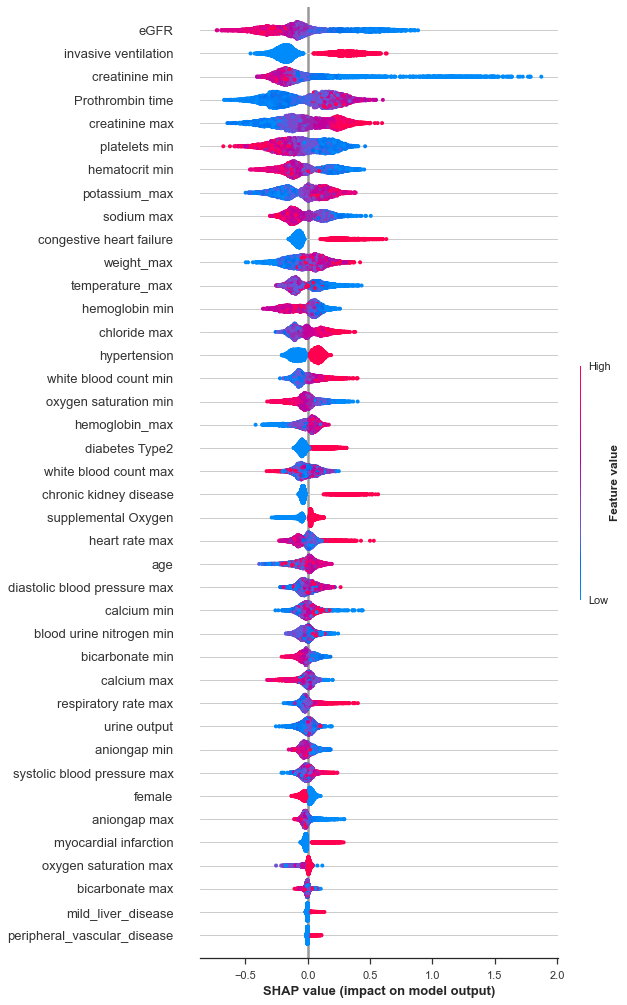

In [74]:
import shap

X_valid_t = scale_impute(df=X_valid,pipe=pipeline_final)
shap.initjs()
explainer = shap.TreeExplainer(pipeline_final._final_estimator)
shap_values = explainer.shap_values(X_valid_t)
shap.summary_plot(shap_values[1], X_valid_t, max_display=40)

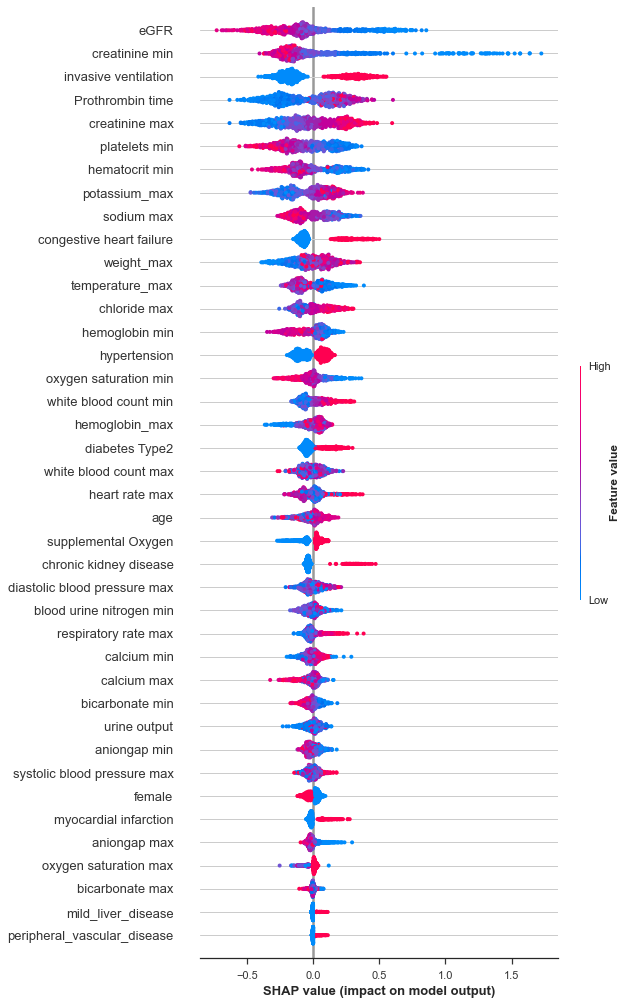

In [75]:
X_sampled = X_valid.sample(1000, random_state=42)

import shap

X_sampled = scale_impute(df=X_sampled,pipe=pipeline_final)
shap.initjs()
explainer = shap.TreeExplainer(pipeline_final._final_estimator)
shap_values = explainer.shap_values(X_sampled)
shap.summary_plot(shap_values[1], X_sampled, max_display=40)

## Histograms (XAI on FP cohort)

In [76]:
df_test_all = X_valid.copy()
df_test_all['y_actual'] = y_valid
df_test_all['y_pred'] = y_pred

In [77]:
# labeling the category of error

pd.options.mode.chained_assignment = None  # To suppress a warning for commands below 

df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 1: # True positive 2
          df_test_all['error_category'][i] = 2
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 0: # False negative 3
          df_test_all['error_category'][i] = 3

# df_test_all

In [78]:
df_TN = df_test_all[df_test_all.error_category==0]
df_FP = df_test_all[df_test_all.error_category==1]

df_TP = df_test_all[df_test_all.error_category==2]
df_FN = df_test_all[df_test_all.error_category==3]

## Break-down plot using Dalex(the main local XAI in the study)

In [79]:
import dalex as dx

exp = dx.Explainer(pipeline_final, X_train, y_train)

Preparation of a new explainer is initiated

  -> data              : 30254 rows 52 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 30254 values
  -> model_class       : lightgbm.sklearn.LGBMClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7fbc002ae310> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0122, mean = 0.503, max = 0.961
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.949, mean = -0.0027, max = 0.942
  -> model_info        : package imblearn

A new explainer has been created!


In [80]:
df_FP_high_scr = df_FP[df_FP['creatinine max']>=1.1]

In [81]:
query = "select * from all_scr_sb_preadmisssion_75_6h_fix"
data_baseline = pd.read_sql_query(query,con,index_col=['stay_id','subject_id'])
data_baseline.drop('hadm_id', inplace=True, axis=1)

In [82]:
df_FP_high_scr_bl = pd.merge(df_FP_high_scr,data_baseline['creatinine_mg_dl'], how='left', on=['stay_id'])

In [ ]:
df_FP_high_scr_bl.rename(columns={'creatinine_mg_dl':'scr_baseline'}, inplace=True)
df_FP_high_scr_bl

In [83]:
import random
import dalex as dx


random.seed(42)
rand_list = random.sample(range(0, df_FP.shape[0]), 1)

clf_threshold = 0.5


# error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
error_df = {"df_FP":df_FP}

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)

    for row_number in rand_list:
        print("Using DALEX on false positive instance with row number: "+str(row_number))
        fig_plot = exp.predict_parts(df_shap.iloc[[row_number]], N=100, label='XGBoost classifier').plot(min_max=[0,1], max_vars=30, baseline=clf_threshold, title='Dalex Break Down plot', show=False)
        fig_plot.update_layout(width=600,height=800)


Using DALEX on false positive instance with row number: 654


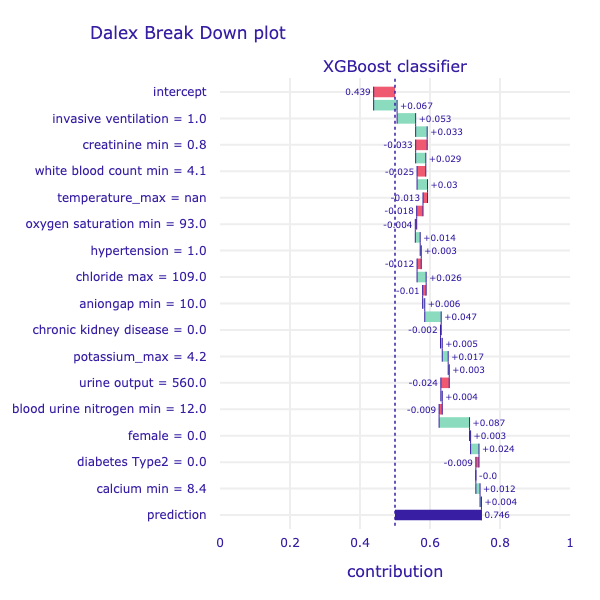

In [84]:
from IPython.display import Image
fig_plot.update_layout(width=600,height=600)
img_bytes = fig_plot.to_image(format="png")
Image(img_bytes)


In [ ]:
fig_plot.update_layout(width=800,height=800)

In [ ]:
import random
import dalex as dx


random.seed(42)
rand_list = random.sample(range(0, df_FP.shape[0]), 30)

clf_threshold = 0.5


# error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
error_df = {"df_FP":df_FP}

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)

    for row_number in rand_list:
        print("Using DALEX on false positive instance with row number: "+str(row_number))
        exp.predict_parts(df_shap.iloc[[row_number]], N=100, label='XGBoost classifier').plot(min_max=[0,1], max_vars=30, baseline=clf_threshold, title='Dalex Break Down plot')
        tmp = data_baseline.loc[df_shap.iloc[[row_number]].index[0]]
        print('SCr baseline: umol/L: '+str((tmp[tmp.day_of_test.min()==tmp.day_of_test].iloc[0].scr_umol_l)/88.4))
        # print('SCr max: umol/L'+str(df_shap.creatinine_max*88.4))

## SHAP plot using Dalex

In [ ]:
# import random
# random.seed(42)
# rand_list = random.sample(range(0, df_FP.shape[0]), 10)

clf_threshold = 0.5
import dalex as dx

# error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
error_df = {"df_FP":df_FP}

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)

    for row_number in rand_list:
        print("Using DALEX SHAP on false positive instance with row number: "+str(row_number))
        exp.predict_parts(df_shap.iloc[[row_number]], N=100, type='shap', label='XGBoost classifier').plot(min_max=[0,1], max_vars=20, baseline=clf_threshold, title='Dalex SHAP plot')

In [ ]:
random.seed(42)
rand_list = random.sample(range(0, df_FP.shape[0]), 30)

clf_threshold = 0.5


# error_df = {"df_TN":df_TN, "df_FP":df_FP, "df_TP":df_TP, "df_FN":df_FN}
error_df = {"df_FP":df_FP}

for k,df in error_df.items():
    df_shap = df.drop(['y_pred','y_actual','error_category'], axis=1)

    for row_number in rand_list:
        print("Using DALEX on false positive instance with row number: "+str(row_number))
        exp.predict_parts(df_shap.iloc[[row_number]], N=100, label='XGBoost classifier').plot(min_max=[0,1], max_vars=30, baseline=clf_threshold, title='Dalex Break Down plot')
        tmp = data_baseline.loc[df_shap.iloc[[row_number]].index[0]]
        print('SCr baseline: umol/L: '+str((tmp[tmp.day_of_test.min()==tmp.day_of_test].iloc[0].scr_umol_l)/88.4))